In [1]:
import mne
from mne.preprocessing import ICA
import autoreject
import pandas as pd
from datetime import datetime
import json
from pathlib import Path
from spectral.ica import compute_ica
from spectral.viz import plot_epochs
from spectral.specparam import specparam2pandas


from spectral.utils import ProjectPaths,print_timestamp

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")
#print_date_time()
subject = 101


paths = ProjectPaths(subject)
# Create all directories
paths.create_directories()

# This is analysis output, so it goes in the analysis folder
specparam_path = paths.specparam
project_path = paths.root
figures_path = paths.figures
preprocessed_path = paths.preprocessed
epochs_path = paths.epochs
# Print paths to verify
print_timestamp("Setting up project paths")
paths.show()

Using matplotlib as 2D backend.
Created directories for sub-101
Project root: /Users/daniel/PhD/Projects/psd-paths
Setting up project paths: 2025-08-14 17:16:50
────────────────────────────────────────────────────────────
Paths for sub-101
Project Root: /Users/daniel/PhD/Projects/psd-paths
────────────────────────────────────────────────────────────
  analysis     : /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/analysis
  data         : /Users/daniel/PhD/Projects/psd-paths/data/raw/sub-101
  epochs       : /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/epochs
  figures      : /Users/daniel/PhD/Projects/psd-paths/outputs/figures/sub-101
  ica          : /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/analysis/ica
  logs         : /Users/daniel/PhD/Projects/psd-paths/data/logs
  outputs      : /Users/daniel/PhD/Projects/psd-paths/outputs
  preprocessed : /Users/daniel/PhD/Projects/psd-paths/data/derrivatives/sub-101/preprocessed
  processin

# Specparam computation

In [2]:
from specparam.plts.spectra import plot_spectra
from specparam import SpectralGroupModel


fg = SpectralGroupModel(
    peak_width_limits=[1, 6],
    min_peak_height=0.15,
    peak_threshold=2.0,
    max_n_peaks=6,
    verbose=False,
)

    Using multitaper spectrum estimation with 7 DPSS windows


/Users/daniel/.pyenv/versions/miniforge3-25.1.1-2/envs/psd-paths-3.13/lib/python3.13/site-packages/scipy/_lib/array_api_compat/common/_aliases.py:552: RuntimeWarning: divide by zero encountered in matmul
  return xp.matmul(x1, x2, **kwargs)
/Users/daniel/.pyenv/versions/miniforge3-25.1.1-2/envs/psd-paths-3.13/lib/python3.13/site-packages/scipy/_lib/array_api_compat/common/_aliases.py:552: RuntimeWarning: overflow encountered in matmul
  return xp.matmul(x1, x2, **kwargs)
/Users/daniel/.pyenv/versions/miniforge3-25.1.1-2/envs/psd-paths-3.13/lib/python3.13/site-packages/scipy/_lib/array_api_compat/common/_aliases.py:552: RuntimeWarning: invalid value encountered in matmul
  return xp.matmul(x1, x2, **kwargs)


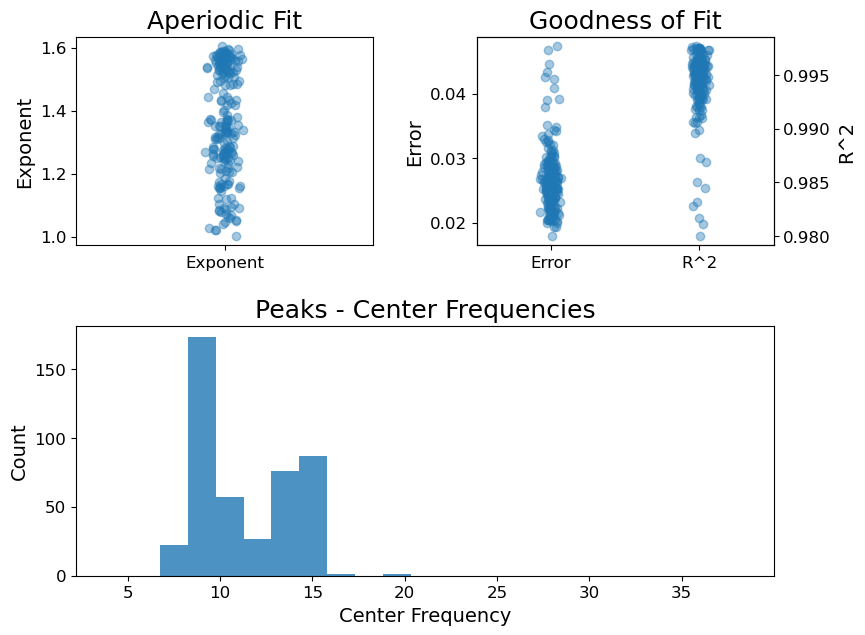

In [3]:
epochs_intepolated_fname = f"{paths.epochs}/sub-{subject}_interpolated-epo.fif"

if not Path(epochs_intepolated_fname).exists():
    raise FileNotFoundError(f"Interpolated epochs not found: {epochs_intepolated_fname}")

epochs_interpolated = mne.read_epochs(epochs_intepolated_fname, preload=True, verbose="warning")

psd = epochs_interpolated.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings

# Define the frequency range to fit
freq_range = [2, 40]
fg.fit(freqs, spectra, freq_range)
fg.plot()

In [4]:
channel_names = epochs_interpolated.info["ch_names"]
df_channels = pd.DataFrame({"ID": range(len(channel_names)), "ch": channel_names})

df = specparam2pandas(fg)
df = df.merge(df_channels, on="ID")
df["sub_id"] = subject


# Get the current date and time
now = datetime.now()
df["timestamp"] = now
df["nr_intepolated_channels"] = len(epochs_interpolated.info["bads"])
try:
    df["nr_dropped_ica"] = len(ica.exclude)
    df["nr_retained_ica"] = ica.n_components_ - len(ica.exclude)
except NameError:
    # No ICA object at all
    pass
except AttributeError:
    # ICA object exists but missing exclude or n_components_
    pass
    # Create a new list of column names
cols = ["ch"] + [col for col in df.columns if col != "ch"]

# Reorder the columns
df = df[cols]
df.to_csv(f"{paths.specparam}/sub-{subject}-specparam.csv", index=False)
print(f"Subject {subject} done")

Subject 101 done


# Plot R and exponent across the scalp


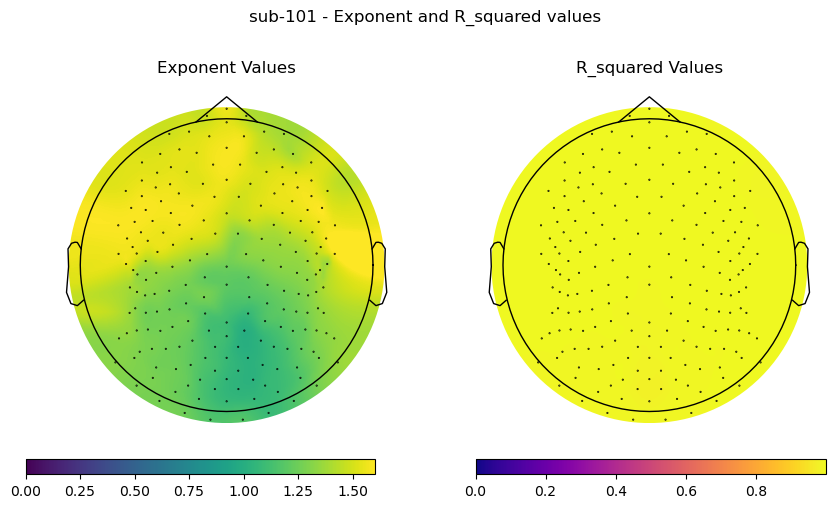

An error occurred while adding the figure to the report: name 'report' is not defined


In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import mne  # Make sure you have the MNE library installe


def exclude_bad_channels(epochs):
    """Modify to MNE object to exclude bad channels"""
    all_channels = epochs.info["ch_names"]
    bad_channels = epochs.info["bads"]
    good_channels = [ch for ch in all_channels if ch not in bad_channels]
    epochs_good = epochs.copy().pick_channels(good_channels)
    return epochs_good


#epochs_ar_good = exclude_bad_channels(epochs_ar)

# Extract aperiodic exponent values
exps = fg.get_params("aperiodic_params", "exponent")
r_squared = fg.get_params("r_squared")

# Assuming 'exps' is your data array and 'raw' is an MNE raw object
# Also, assuming 'unit_label' and 'fontsize' variables are defined

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# The 'cmap' parameter expects a colormap object, not a string
im1, _ = mne.viz.plot_topomap(
    exps, epochs_interpolated.info, axes=axs[0], cmap="viridis", contours=0, show=False
)
axs[0].set_title("Exponent Values")

#  Colorbar setup for the first subplot at the bottom
cbar_ax1 = fig.add_axes([0.1, 0.05, 0.35, 0.03])
fig.colorbar(im1, cax=cbar_ax1, orientation="horizontal")


# Plot the 'errors' data in the second subplot
im2, _ = mne.viz.plot_topomap(
    r_squared,
    epochs_interpolated.info,
    axes=axs[1],
    cmap="plasma",
    contours=0,
    show=False,
)
axs[1].set_title("R_squared Values")

# Colorbar setup for the second subplot at the bottom
cbar_ax2 = fig.add_axes([0.55, 0.05, 0.35, 0.03])
fig.colorbar(im2, cax=cbar_ax2, orientation="horizontal")
fig.suptitle(f"sub-{subject} - Exponent and R_squared values")

plt.show()
try:
    report.add_figure(fig, title="Exponent and R_squared values")
except Exception as e:
    # If an exception occurs, print the error message
    print("An error occurred while adding the figure to the report:", e)
# Save the DataFrame to a CSV file

An error occurred while adding the figure to the report: name 'report' is not defined


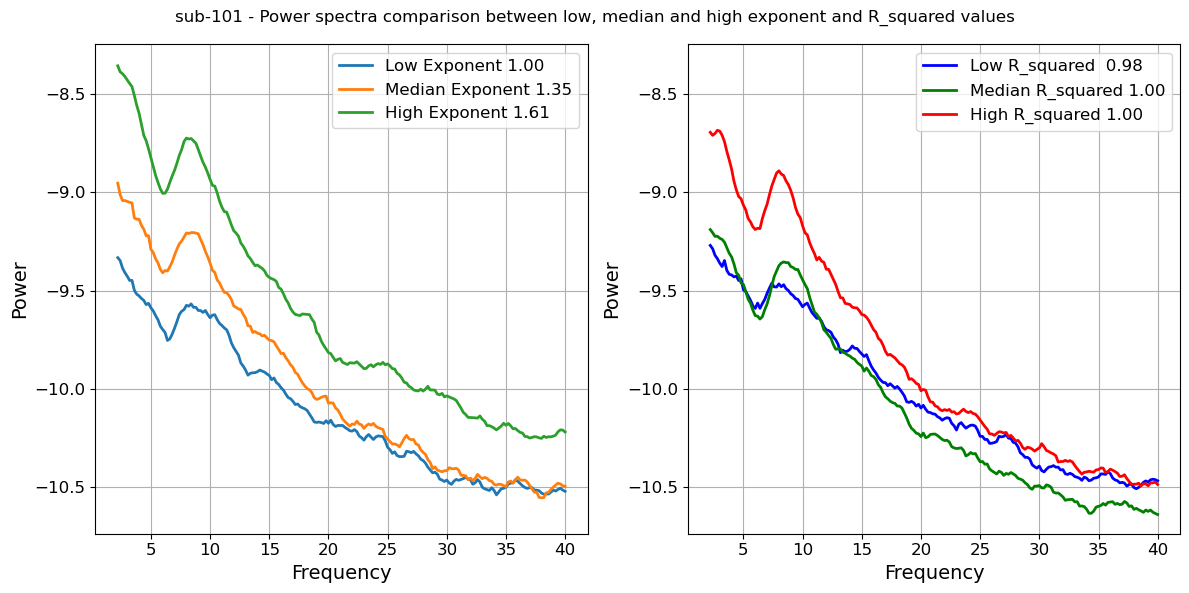

In [6]:
# Compare the power spectra between low and high exponent channels
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


def argmedian(arr):
    return np.argsort(arr)[len(arr) // 2]


spectra_exp = [
    fg.get_model(np.argmin(exps)).power_spectrum,
    fg.get_model(argmedian(exps)).power_spectrum,
    fg.get_model(np.argmax(exps)).power_spectrum,
]

labels_spectra_exp = [
    f"Low Exponent {format(np.min(exps), '.2f')}",
    f"Median Exponent {format(np.median(exps), '.2f')}",
    f"High Exponent {format(np.max(exps), '.2f')}",
]

plot_spectra(
    fg.freqs,
    spectra_exp,
    ax=ax[0],
    labels=labels_spectra_exp,
)

spectra_r_squared = [
    fg.get_model(np.argmin(r_squared)).power_spectrum,
    fg.get_model(argmedian(r_squared)).power_spectrum,
    fg.get_model(np.argmax(r_squared)).power_spectrum,
]


labels_spectra_r_squared = [
    f"Low R_squared  {format(np.min(r_squared), '.2f')}",
    f"Median R_squared {format(np.median(r_squared), '.2f')}",
    f"High R_squared {format(np.max(r_squared), '.2f')}",
]


my_colors = ["blue", "green", "red"]
plot_spectra(
    fg.freqs,
    spectra_r_squared,
    ax=ax[1],
    labels=labels_spectra_r_squared,
    colors=my_colors,
)
ylim1 = ax[0].get_ylim()
ylim2 = ax[1].get_ylim()
# Set the same limits on the y-axis for both plots
ax[0].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
ax[1].set_ylim(min(ylim1[0], ylim2[0]), max(ylim1[1], ylim2[1]))
fig.suptitle(
    f"sub-{subject} - Power spectra comparison between low, median and high exponent and R_squared values"
)

try:
   report.add_figure(
    fig, title="Examples of spectra as a function of exponent and R_squared values"
   )
   report.save(
    f"{paths.reports}/sub-{subject}_report.html", overwrite=True
)
except Exception as e:
    # If an exception occurs, print the error message
    print("An error occurred while adding the figure to the report:", e)



                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -8.9282, 1.0033                                          
                                                                                                  
                                       2 peaks were found:                                        
          

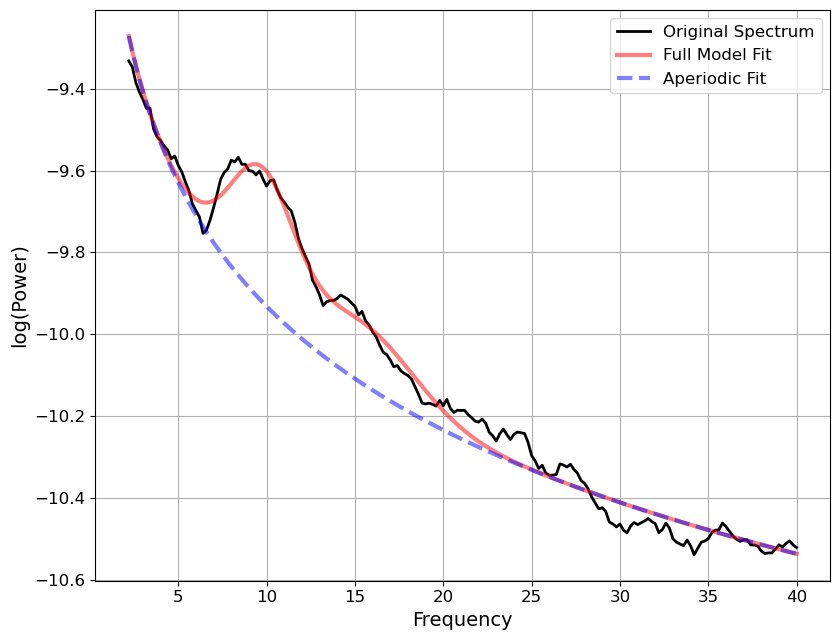

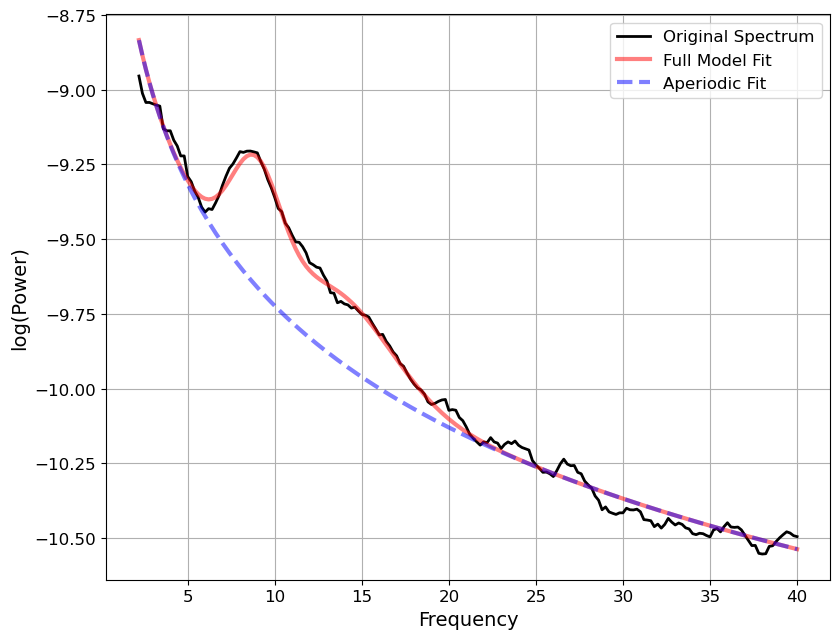

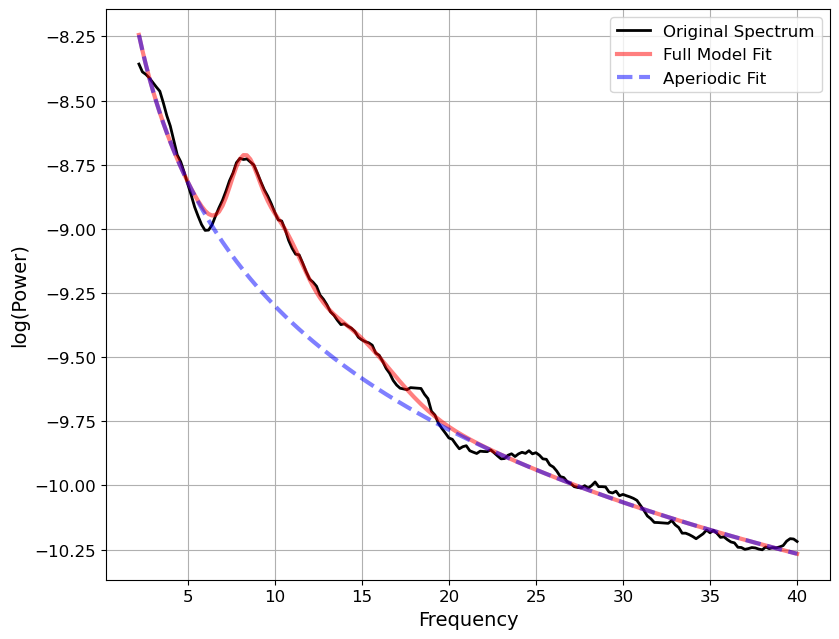

In [7]:
spectra_exp_fm = [
    fg.get_model(np.argmin(exps), regenerate=True),
    fg.get_model(argmedian(exps), regenerate=True),
    fg.get_model(np.argmax(exps), regenerate=True),
]
for fm, label in zip(spectra_exp_fm, labels_spectra_exp):
    # fm = fg.get_fooof(ind=2, regenerate=True)
    # Print results and plot extracted model fit
    fm.print_results()
    fm.plot()
    print(label)

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -8.8000, 1.0420                                          
                                                                                                  
                                       1 peaks were found:                                        
          

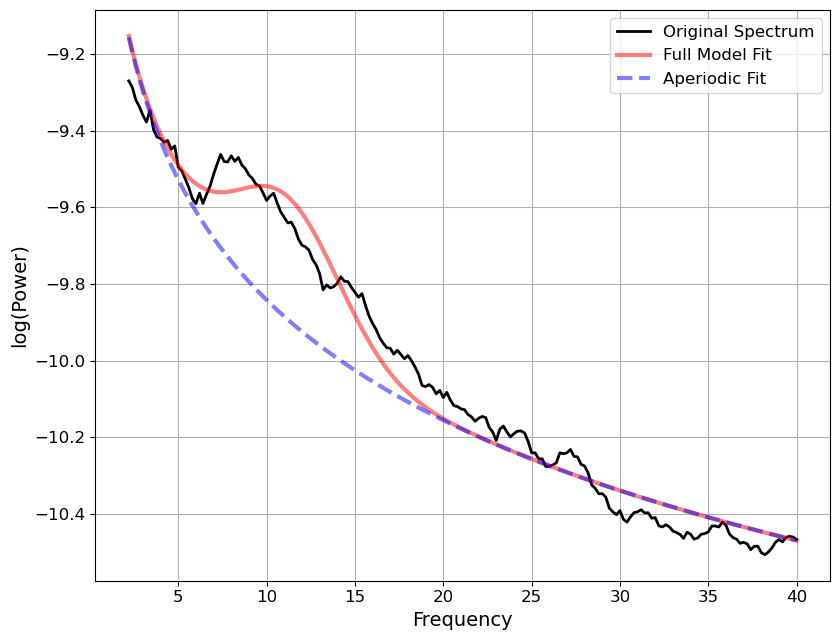

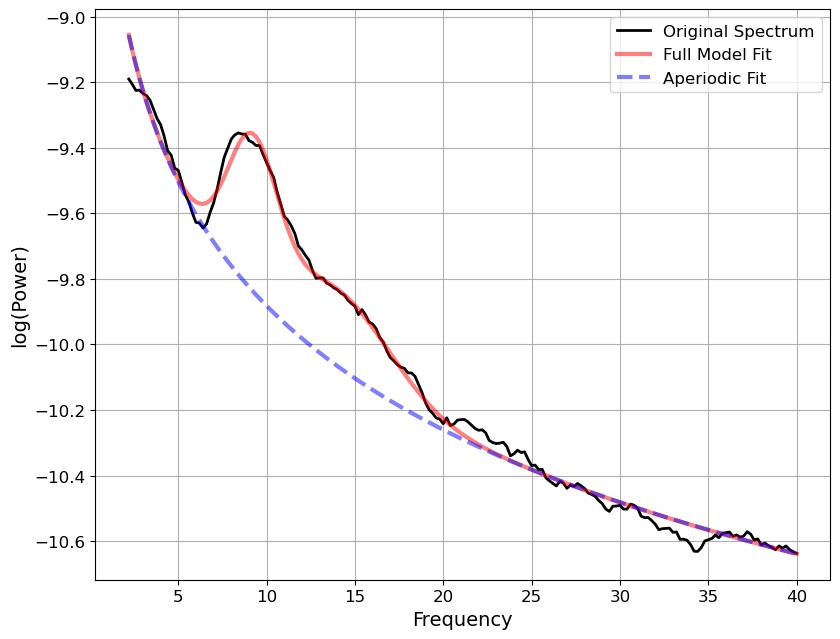

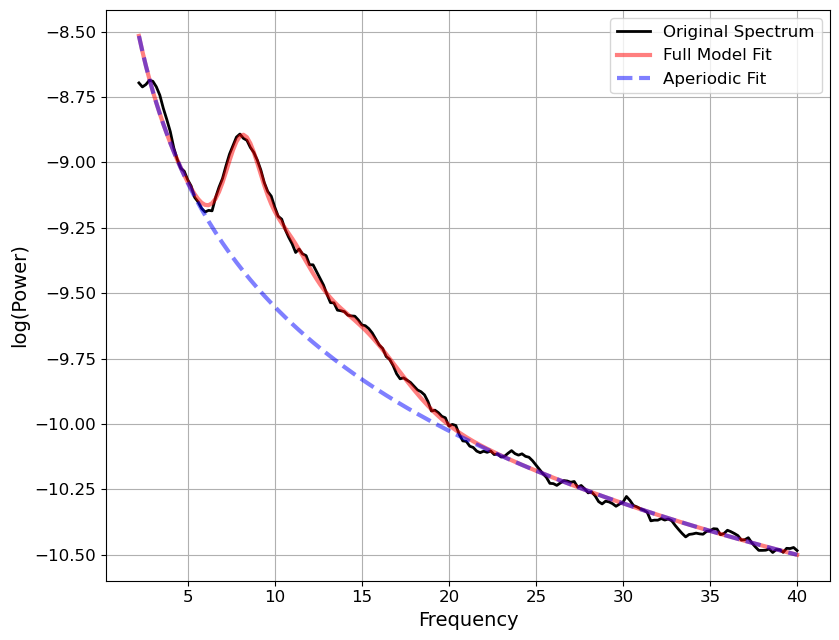

In [8]:
spectra_r_squared_fm = [
    fg.get_model(np.argmin(r_squared), regenerate=True),
    fg.get_model(argmedian(r_squared), regenerate=True),
    fg.get_model(np.argmax(r_squared), regenerate=True),
]

for fm, label in zip(spectra_r_squared_fm, labels_spectra_r_squared):
    # fm = fg.get_fooof(ind=2, regenerate=True)
    # Print results and plot extracted model fit
    fm.print_results()
    fm.plot()
    print(label)